In [41]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import glob
from sklearn.utils import shuffle
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


def get_N_matrix(topic, verbose=True):
    MEDIA = ['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']
    cv = CountVectorizer(max_df=0.9, min_df=10, max_features=10000, ngram_range=(1,3))

    df = pd.read_csv('../data/sorted/'+topic+'.csv', index_col=0)
    cv.fit(df['preprocessed'])

    df['preprocessed'] = df['preprocessed'] + ' '
    df = df[['medium', 'preprocessed', 'dominant topic']]
    df_grouped = df.groupby(['medium', 'dominant topic']).sum()

    df = pd.DataFrame(index=MEDIA, columns=['preprocessed'])
    for medium in MEDIA:
        df.loc[medium] = df_grouped.loc[medium].loc[topic]['preprocessed']

    
    N_matrix = cv.transform(df['preprocessed'].values)

    N_df = pd.DataFrame(data=N_matrix.toarray().transpose(),
                        columns=df.index,
                        index=cv.get_feature_names_out())

    return N_df

In [40]:
n = 20000

N_df = get_N_matrix('Ukrainekonflikt')
N_df['sum'] = N_df.sum(axis=1)
N_df.sort_values(by=['sum'], inplace=True)
N_df.drop(columns=['sum'], inplace=True)
N_df = N_df.iloc[:n]


In [ ]:
def relu(x):
    return np.maximum(0.0, x)

def convert_x_to_uvw(x):
    u = np.reshape(x[:u_guess.size], u_shape)
    v = np.reshape(x[u_guess.size:u_guess.size+v_guess.size], v_shape)
    w = np.diag(x[u_guess.size+v_guess.size:])
    return u, v, w

def convert_uvw_to_x(u, v, w):
    u = u[:,:r].flatten()
    w = [w[i, i] for i in range(r)]
    v = v[:r, :].flatten()
    return np.append(np.append(u, v), w)

def objective(x):
    global N_df
    #u, v, w = convert_x_to_uvw(x)
    #mu = u.dot(w).dot(v)
    x = x.reshape(len(N_df.index), len(N_df.columns))
    #svd.fit_transform(N_df)
    fitted = svd.fit_transform(x)
    mu = relu(svd.inverse_transform(fitted))
    P_matrix = poisson.pmf(k=N_df.values, mu=mu)
    loss_function = -1.0*np.log(np.product(P_matrix, axis=None))
    return loss_function

def constraint_1(x):
    u, v, w = convert_x_to_uvw(x)
    v = np.zeros(v.shape)
    w = np.zeros(w.shape)
    u_unitary = u.dot(u.transpose())# - np.diag(np.ones(u_shape[0]))
    if np.allclose(u_unitary, np.diag(np.ones(u_shape[0]))):
        return 0
    else:
        return 1
    #return np.sum(u, axis=0) #convert_uvw_to_x(u, v, w) 

def constraint_2(x):
    u, v, w = convert_x_to_uvw(x)
    u = np.zeros(u.shape)
    w = np.zeros(w.shape)
    v_unitary = v.dot(v.transpose())# - np.diag(np.ones(v_shape[0]))
    if np.allclose(v_unitary, np.diag(np.ones(v_shape[0]))):
        return 0
    else:
        return 1
    #return np.sum(v, axis=0) #convert_uvw_to_x(u, v, w)


r = 3
svd = TruncatedSVD(n_components=r)

u_shape = (len(N_df.index), r)
v_shape = (r, len(N_df.columns))
w_shape = (r)

u_guess = np.zeros(u_shape[0]*u_shape[1])
v_guess = np.zeros(v_shape[0]*v_shape[1])
w_guess = np.zeros(w_shape)

#x0 = np.append(np.append(u_guess, v_guess), w_guess)
np.random.seed(42)
x0 = np.random.rand(len(N_df.index)*len(N_df.columns))
#bounds = [(0, None) if i>=u_shape[0]*u_shape[1]+v_shape[0]+v_shape[1] else (None, None) for i in range(x0.size)]
bounds = [(0, 10*len(N_df.index)) for i in x0]
con1 = {'type':'eq', 'fun':constraint_1}
con2 = {'type':'eq', 'fun':constraint_2}
cons = [con1, con2]

sol = minimize(fun=objective, x0=x0, bounds=bounds)#, constraints=cons)
#u, v, w = convert_x_to_uvw(sol.x)
#lambda_matrix = u.dot(w.dot(v))


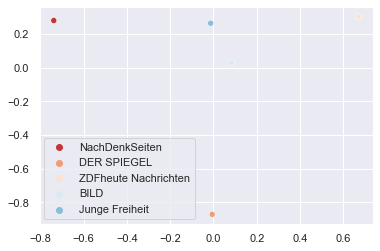

In [27]:
r=3

model = TruncatedSVD(n_components=r)
N_df_trunc = model.fit_transform(N_df.values)

sns.set(palette='RdBu', style='darkgrid')
sns.scatterplot(svd.components_[1], svd.components_[2], hue=['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit'])
plt.show()